# MODULE 1: TIME SERIES SEGMENTATION USING GMMs

### Dataset link for the Dataset used in Module 1 
https://github.com/owid/covid-19-data/tree/master/public/data (https://ourworldindata.org/coronavirus-source-data)

We can just download the latest datasets and run the code to get the revised Predictions

https://api.covid19india.org/csv/latest/case_time_series.csv 

# Import required packages

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
import matplotlib.dates as mdates
from datetime import datetime

%matplotlib inline
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

# Data Preprocessing


Loading the Dataset from the <b>Different Countries</b>, the idea is to learn the stage transitions using 
the countries in which CORONA-VIRUS is already saturated. 

Current list of Countries to use: 
<b> 'Australia', 'Switzerland', 'China', 'India', 'Iceland','South Korea', 'New Zealand','Austria'] </b>



In [204]:
#############################################################################################
###########  Reading the Dataset and Filtering Data for Mature Countries  ###################
#############################################################################################

df =  pd.read_csv('../Data/14th July/owid-covid-data.csv', encoding = 'utf8')
countries = ['Australia', 'Switzerland', 'China', 'India', 'Iceland','South Korea', 'New Zealand','Austria'] 
df = df[df['location'].isin(countries)]

#############################################################################################
####################  Coversion to Date Time Format  ########################################
#############################################################################################

## Function Definition
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

## Applying the function
Dates= df.apply(lambda row: date_conversion(row.date), axis = 1)
df.insert(3,'Dates',Dates)
df.drop('date',axis =1,inplace=True)
df_new = df[df['total_cases']>0].copy()

#############################################################################################
#################  Adding a column storing cumulative number of days ########################
#############################################################################################

country_list = list(df['location'].unique()) 

## Function for identifying the first date
def get_first_day(country_list,df):
    f_day = [df.loc[df[df['location']==i].index[0]].Dates for i in country_list]
    return f_day

first_occurence = get_first_day(country_list, df_new)
print(first_occurence)

## Function to count number of cummulative days
def cumulative_day(country, Dates, first_occurence,country_list):
    val = (Dates - first_occurence[country_list.index(country)]).days + 1
    return val

cum_day = df_new.apply(lambda row: cumulative_day(row.location,row.Dates,first_occurence, country_list), axis = 1)
df_new.insert(3, 'cum_day',cum_day)

#############################################################################################
#################### Removing the Outlier Data Point  #######################################
#############################################################################################

## Removing the Abonormal Data point for China
df_new.drop(df_new[(df_new['location']=='China') & (df_new['new_cases']==15141)].index, axis = 0, inplace=True)
df_new.head()

#############################################################################################
###################  Removing the Dataset After a Particular Date ###########################
#############################################################################################
start_date = pd.to_datetime('2020-06-30', format='%Y-%m-%d')
whole_data = df_new
training_data = df_new[df_new['Dates']<= start_date]

del df_new
del df

[datetime.date(2020, 1, 25), datetime.date(2020, 2, 26), datetime.date(2019, 12, 31), datetime.date(2020, 2, 29), datetime.date(2020, 1, 30), datetime.date(2020, 2, 28), datetime.date(2020, 1, 20), datetime.date(2020, 2, 26)]


In [205]:
#############################################################################################
######################    Data Visualization Function    ####################################
#############################################################################################

## Generates the bar plot of number of cases
def barplot(country):
    
    plt.figure(figsize=(16,8))
    ax= sns.barplot(x= "cum_day", y = "new_cases", data = df_new[df_new['location']==country],palette='binary_r')
    ax.set(xlabel='Days', ylabel='Number of incoming cases')
    plt.title('Barplot of '+ country)

    ##plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' barplot.png',dpi = 500)
    plt.show()
    
## Generates the distplot of the number of cases
def distplot(country):
    plt.figure(figsize=(16,8))
    ax = sns.distplot(df_new[df_new['location']==country].new_cases,color='k')
    ax.set(xlabel = 'New Cases', ylabel = 'Proportion')
    plt.title('Distplot of '+ country)

    ## plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' distplot.png',dpi = 500)
    plt.show()
    

# Model Selection

1429      1.0
1430      3.0
1431      0.0
1432      0.0
1433      0.0
         ... 
26476    52.0
26477    58.0
26478    69.0
26479    62.0
26480    35.0
Name: new_cases, Length: 1145, dtype: float64


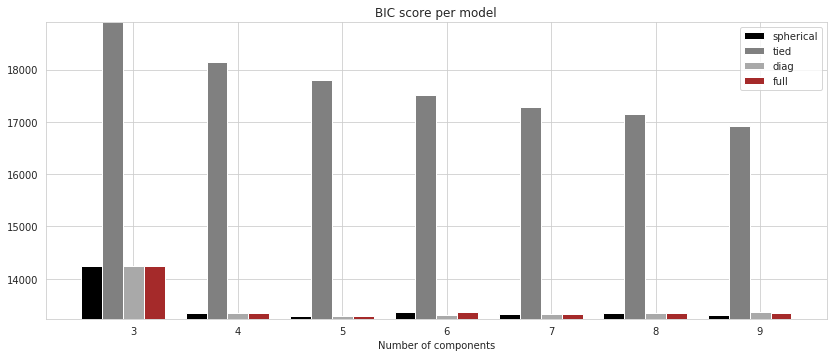

In [206]:
## Vary the number of components and the covariance type to get the best fit
cases_counts = training_data.new_cases
print(cases_counts)
day = training_data.cum_day
X = np.reshape(np.array(cases_counts),(-1,1))
#print(X)

np.random.seed(0)
lowest_bic = np.infty

bic = []
n_components_range = range(3, 10)

## Covariance Type
cv_types = ['spherical', 'tied', 'diag', 'full']


#############################################################################################
####################  Model Fitting with Different Parameters  ##############################
#############################################################################################

## Fitting the best model using a grid search cv on Covariance Type & 
## Number of Components on the basis of Bayesian Information Criterion 
for cv_type in cv_types:
    
    for n_components in n_components_range:
        
        ## Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['black', 'grey', 'darkgrey','brown'])
clf = best_gmm
bars = []

#############################################################################################
######################    Visualization of the BIC Score     ################################
#############################################################################################

## Plot the BIC scores
plt.figure(figsize=(14,12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)],width=.2, color=color))

    
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))

spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [207]:
## To plot the result of the code. Gives the counts of daily incoming cases color coded with the stage they belong to. 
def plot_results(country):
    plt.figure(figsize=(16,4))
    plt.scatter(training_data[training_data['location']==country].cum_day,training_data[training_data['location']==country].new_cases,c=training_data[training_data['location']==country].Stages)
    
    ## To undestand the number of components which can be used
    plt.title('Day-wise Counts and Stages for '+country) 
    plt.xlabel('Day')
    plt.ylabel('Counts')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
    ## plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ ' +country+' counts and stages.png',dpi = 500)
    plt.show()
    
## Generates the Cluster vs Stages if called
def clustervsstages(country):
    plt.figure(figsize=(16,4))
    plt.scatter(training_data[training_data['location']==country].cum_day,training_data[training_data['location']==country].Stages,
            c=training_data[training_data['location']==country].Stages)
    plt.title('Day-wise stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
    ## plt.savefig('D:\Studies\Corona Research\Plots\Daywise Stages\ ' +country+' daywise stages.png',dpi = 500)
    plt.show()

# Determining the outbreak

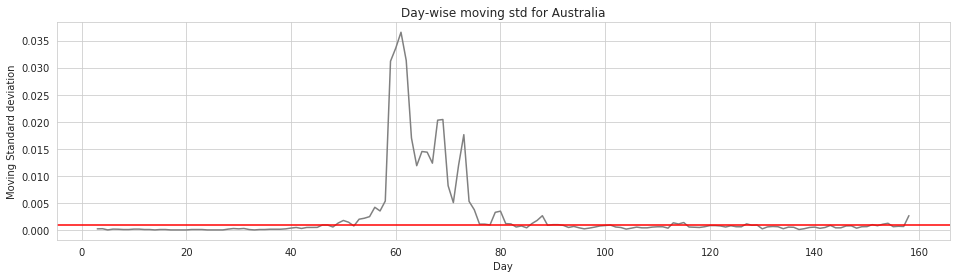

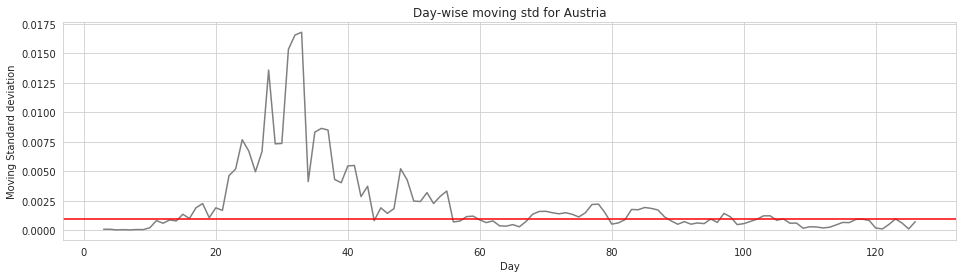

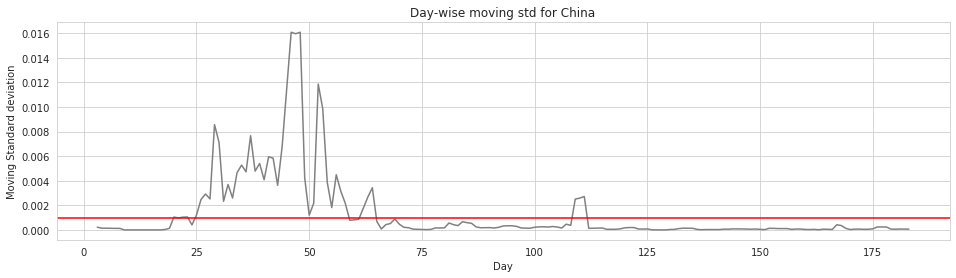

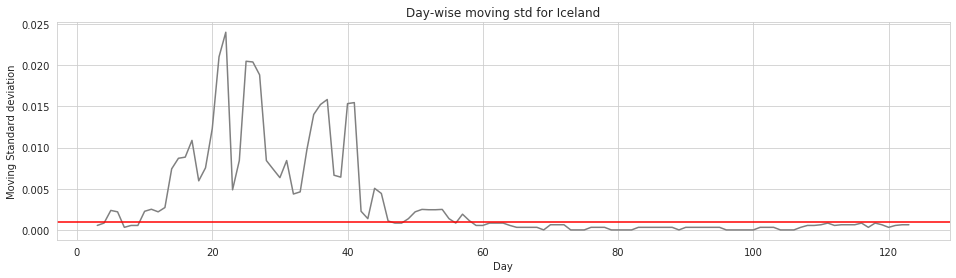

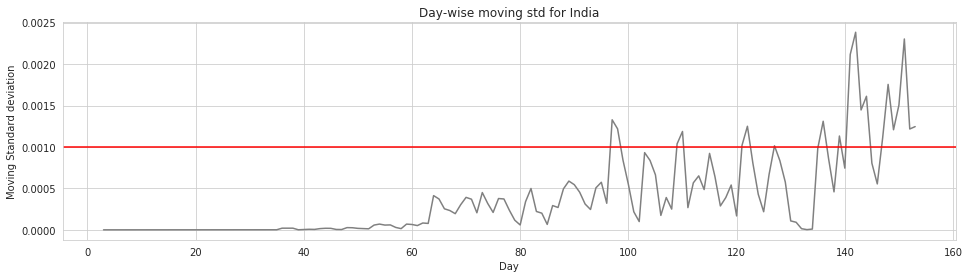

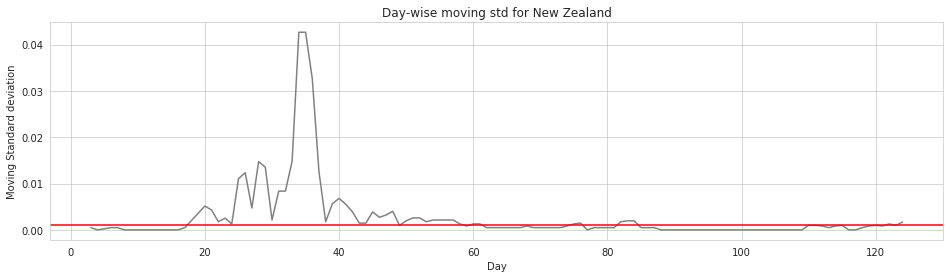

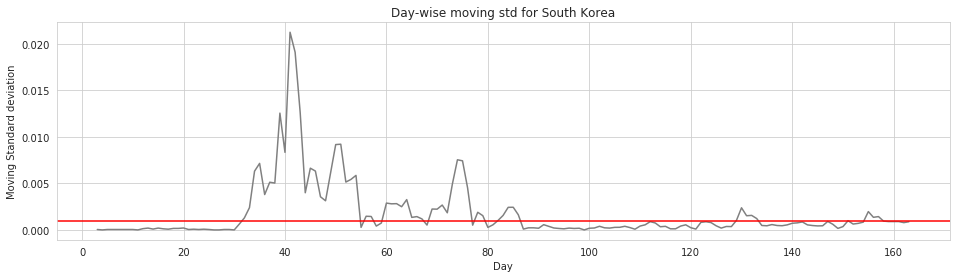

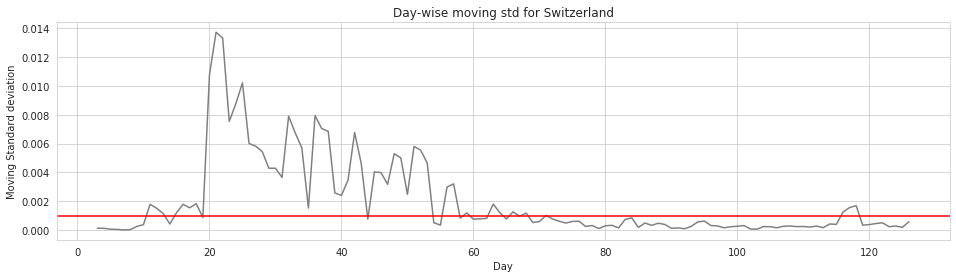

In [208]:
df_std = training_data.copy()
rol = []

## To Scale the Data
for item in country_list:
    normalised_std = df_std[df_std['location']==item].new_cases/(df_std[df_std['location']==item].new_cases.sum())
    
    ## Used to get moving standard deviation
    rol.extend(normalised_std.rolling(3).std())

## Add a column as rolling std
df_std['rolling_std']=rol
df_std.drop(df_std[df_std.rolling_std.isna()==True].index,inplace=True)

## Generates country wise plot to visualise the threshold for determining the outbreak
for item in country_list:
    plt.figure(figsize=(16,4))
    plt.plot(df_std[df_std['location']==item].cum_day,df_std[df_std['location']==item].rolling_std,color='grey')
    plt.title('Day-wise moving std for '+item) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Moving Standard deviation')
    plt.axhline(y=0.001,color='r')
    ## cbar = plt.colorbar()
    ## cbar.set_label('Stages')
    plt.savefig(item+' moving std.png',dpi = 500)
    plt.show()

In [209]:
## Filtering the data based on the threshold for the outbreak
df_training = df_std[~df_std['location'].isin(['India'])]
df_training = df_std[df_std['rolling_std']>=0.001]

## Determines the cumulative day since outbreak
df_training.drop(['cum_day'],axis =1,inplace=True)
days_since_outbreak = df_training.apply(lambda row: cumulative_day(row.location,row.Dates,get_first_day(country_list, df_training), country_list), axis = 1)
df_training.insert(3, 'days_outbreak',days_since_outbreak)

/home/prerit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [210]:
#######################################################################################
#######################################################################################
#################  GMM + PMM to Segment the Time Series ###############################
#######################################################################################
#######################################################################################

#######################################################################################
#########################  Model Training Function ####################################
#######################################################################################
def groupby_generator(n_mixtures,df):
    data_list = []

    input_data = np.reshape(np.array(df.new_cases),(-1,1))
    input_data_gmm = pd.concat([df.days_outbreak, df.new_cases], axis =1)
    gmm = mixture.GaussianMixture(n_components=n_mixtures,covariance_type='full')
    gmm.fit(input_data_gmm)
    means=gmm.means_
    
    d1 = PoissonDistribution(means[0][1])
    d2 = PoissonDistribution(means[1][1])
    d3 = PoissonDistribution(means[2][1])
    d4 = PoissonDistribution(means[3][1])
    model = GeneralMixtureModel([d1,d2,d3,d4])
    model.fit(input_data)
    return model

######################################################################################
#########################  Generating Predictions Function ###########################
######################################################################################
def output_generator(n_mixtures,model,input_data):
    
    ## Sequence of the Model 
    sequence = model.predict(input_data)
    unique_elements, counts_elements = np.unique(sequence, return_counts=True)
    #print(unique_elements)
    ## model.clear_summaries()
    
    para = []
    for i in range(n_mixtures):
        para.append(model.distributions[i].parameters)

    #for getting the stages based on the components                 
    rank = rankdata(para, method='ordinal')
    print(sequence)
    print(rank)
    stages = []
    for _ in range(len(sequence)):
        if sequence[_]==0:
            stages.append(rank[0])
            continue
        elif sequence[_]==1:
            stages.append(rank[1])
            continue
        elif sequence[_]==2:
            stages.append(rank[2])
            continue
        else:
            stages.append(rank[3])
        
    data_list = [(para),list(zip(unique_elements,counts_elements)),stages, sequence]
    ## dicti[country_list[j]] =data_list
    return data_list


In [211]:
######################################################################################
#########################  Preparation of Training Data  #############################
######################################################################################
df_training = df_training[~df_training['location'].isin(['India'])].groupby(['days_outbreak']).sum()
df_training.reset_index(inplace=True)

######################################################################################
#########################  Model Training  ###########################################
######################################################################################
trained_model = groupby_generator(4,df_training)
prediction_data_group =  np.reshape(np.array(df_training.new_cases),(-1,1))
output_data_group = output_generator(4,trained_model,prediction_data_group)
df_training['Stages_g']=output_data_group[2]


[2 0 2 2 2 2 2 3 2 1 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 2 1 3 3 3 3 3 2 2 3 2 2
 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 4 2 3]


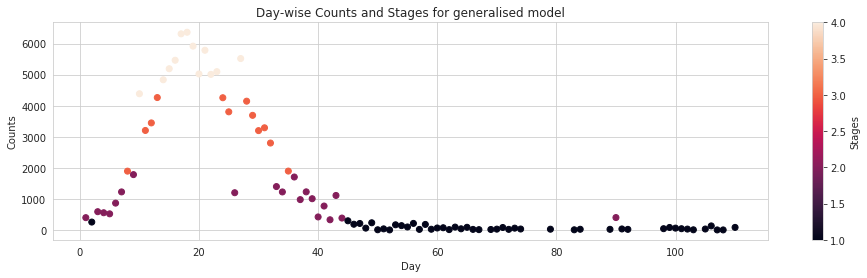

In [11]:
#To plot the result of the code. Gives the counts of daily incoming new_cases color coded with the stage they belong to.
plt.figure(figsize=(16,4))
plt.scatter(df_training[:-3].days_outbreak,df_training[:-3].new_cases,c=df_training[:-3].Stages_g,)
plt.title('Day-wise Counts and Stages for generalised model') #to undestand the number of components which can be used
plt.xlabel('Day')
plt.ylabel('Counts')
cbar = plt.colorbar()
cbar.set_label('Stages')
plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ '+'generalised'+' counts and stages.png',dpi = 500)
plt.show()


# MODULE 2: MARKOV MODULE 

In [12]:
def transition_matrix(arr, n=1):
    """"
    Computes the transition matrix from Markov chain sequence of order `n`.

    :arr: Discrete Markov chain state sequence in discrete time with states in 0, ..., N
    :param n: Transition order
    """

    M = np.zeros(shape=(max(arr) , max(arr) ))
    for (i, j) in zip(arr, arr[1:]):
        M[i-1, j-1] += 1

    T = (M.T / M.sum(axis=1)).T

    return np.linalg.matrix_power(T, n)

In [13]:
tpm_group = transition_matrix(df_training.Stages_g)

In [198]:
pd.DataFrame(tpm_group)

,0,1,2,3
0,0.959184,0.040816,0.000000,0.000000
1,0.150000,0.650000,0.100000,0.100000
2,0.000000,0.333333,0.583333,0.083333
3,0.000000,0.000000,0.250000,0.750000


In [15]:
np.linalg.matrix_power(tpm_group,30)

array([[0.65035828, 0.16298318, 0.09332927, 0.09332927],
       [0.59896318, 0.17794974, 0.11154354, 0.11154354],
       [0.58260095, 0.18271454, 0.11734225, 0.11734225],
       [0.56068262, 0.18909725, 0.12511007, 0.12511007]])

In [16]:
np.linalg.matrix_power(tpm_group,50)

array([[0.62977915, 0.16897595, 0.10062245, 0.10062245],
       [0.6209866 , 0.17153639, 0.10373851, 0.10373851],
       [0.61818739, 0.17235154, 0.10473054, 0.10473054],
       [0.61443765, 0.17344348, 0.10605943, 0.10605943]])

In [17]:
#Given a TPM and initial state, helps to get the first passage time
def first_passage_time(tpm,init_state):
    step_1 = np.delete(tpm,init_state-1,1)
    step_2 = np.delete(step_1,init_state-1,0)
    a = step_2-np.identity(step_1.shape[1])
    b = -1*np.ones(step_2.shape[0])
    val = np.linalg.solve(a,b)
    return val
    
    

In [199]:
f1 = first_passage_time(tpm_group,1)
f2 = first_passage_time(tpm_group,2)
f3 = first_passage_time(tpm_group,3)
f4 = first_passage_time(tpm_group,4)
concatenated = np.array([f1,f2,f3,f4])
fpt = np.zeros((4,4))
for i in range(4):
    k =0 
    for j in range(4):
        if (i!=j):
            fpt[i,j]=concatenated[i,k]
            k+=1
pd.DataFrame(fpt)

,0,1,2,3
0,0.000000,14.666667,18.666667,22.666667
1,24.500000,0.000000,4.000000,8.000000
2,49.875000,25.375000,0.000000,4.000000
3,65.458333,40.958333,35.166667,0.000000


In [19]:
def getStages(fpt,second_last,last,predict_range): ## assumes index 1-4 in input
    fpt1 = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):
            if i>j:
                fpt1[i,j]=fpt[i,j]-fpt[i,j+1]
            elif (i<j):
#                 print(i,j)
                fpt1[i,j]=fpt[i,j]-fpt[i,j-1]
#     print(fpt1)
    seq = []
    
    if(second_last<last):
        if(last!=4):
            temp_arr = fpt1[last-1]
            for x in range(last-1,4):
                for i in range(1,int(temp_arr[x]-1)):
                    seq.append(x)
                seq.append(x+1)
            last+=1
        temp_arr = fpt1[3]
        for x in range(4,1,-1):
            for i in range(1,int(temp_arr[x-2]-1)):
                seq.append(x)
            seq.append(x-1)
            
    else:
        temp_arr = fpt1[last-1]
        for x in range(last,1,-1):
            for i in range(1,int(temp_arr[x-2]-1)):
                seq.append(x)
            seq.append(x-1)
#     print(seq)
    if len(seq)<predict_range:
        for j in range(predict_range-len(seq)):
            seq.append(1)
    else:
        seq = seq[:predict_range]
    return list(seq)

In [20]:
df_seq = df_std[df_std['rolling_std']>=0.000]

In [21]:
#Generating data with stages as output. These stages are used by module 3 for further forecasting.
stage = []
for item in country_list:
    val = df_seq[df_seq['location']==item].new_cases
    pred =  np.reshape(np.array(val),(-1,1))
    output = output_generator(4,trained_model,pred)
    stage.extend(output[2])
df_seq['Stages'] = stage
print(len(stage))
print(stage)

[0 2]
[0 2]
[0 1 2]
[0]
[0 1 2 3]
[0]
[0 2]
[0 2]
1129
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,

In [22]:
df_seq = df_seq[df_seq['location'].isin(['India'])]
whole_data = whole_data[whole_data['location'].isin(['India'])]

In [196]:
Stages = df_seq[['Dates', 'Stages']]

,Dates,Stages
145,2020-06-26,4
146,2020-06-27,4
147,2020-06-28,4
148,2020-06-29,4
149,2020-06-30,4


In [197]:
Stages.to_csv('Stages_30th_June.csv')

In [23]:
df_seq = df_seq.drop(['tests_units','population','population_density','median_age', 'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','rolling_std','cvd_death_rate','handwashing_facilities','iso_code'], axis = 1)
whole_data = whole_data.drop(['tests_units','population','population_density','median_age', 'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy','cvd_death_rate','handwashing_facilities','iso_code'], axis = 1)

In [24]:
df_seq = df_seq.reset_index().drop('index', axis = 1)

In [25]:
df_seq.to_csv('Covid_cases_and_stages_June_30.csv')

### Dataset link for the Dataset used in Module 3.1  
We can just download the latest datasets and run the code to get the revised Predictions

https://api.covid19india.org/csv/latest/case_time_series.csv 

# MODULE 3.1:  SIRD Model For Baseline Predictions

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
from sklearn.linear_model import Ridge
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate



In [27]:
#Loading the dataset
df =  pd.read_csv('../Data/14th July/case_time_series.csv', encoding = 'utf8')

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string+' '+str(2020), '%d %B %Y')
    return datetime_object.date()

df['Date']= df.apply(lambda row: date_conversion(row.Date), axis = 1)

df = df[df['Date']<=start_date]

## Backward Generator Data Preparation
df_n = df[df['Total Confirmed']>=6]
bkwd_pred_range = len(df_n)-2

In [28]:
dates = list(df_n.Date)
date1 = dates[0]
date2 = dates[-1]
# date3 = dates[-8]
print(date1, date2)

2020-03-03 2020-06-30


In [29]:
def get_first_day(df):
    return df.loc[0].Date
first_occurence = get_first_day(df)

## Cumulative Date Column Addition
def cumulative_day(Dates,first_occurence):
    val = (Dates-first_occurence).days + 1
    return val

# cum_day('China',first_occurence[0],first_occurence, country_list)
df['cum_day'] = df.apply(lambda row: cumulative_day(row.Date,first_occurence), axis = 1)
# df_new.insert(3, 'cum_day',cum_day)

threshold = 6
df['infected_t'] = df['Total Confirmed'] - df['Total Recovered'] - df['Total Deceased']
df_beta = df[df['Total Confirmed']<threshold]
df = df[df['Total Confirmed']>=threshold]


In [30]:
def cal_parameters(data):
    data['beta_t']=(-data['infected_t'].diff(periods=-1)  - data['Total Recovered'].diff(periods=-1)-
                    data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['beta_t']<0]['beta_t']=0
    data['gamma_t'] = (- data['Total Recovered'].diff(periods=-1))/((data['infected_t']))
    data[data['gamma_t']<0]['gamma_t']=0.0769
    data['mu_t'] = (- data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['mu_t']<0]['mu_t']=0
    return data


In [31]:
df = cal_parameters(df)
df_beta = cal_parameters(df_beta)

In [32]:
df_beta.tail()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,cum_day,infected_t,beta_t,gamma_t,mu_t
28,2020-02-27,0,3,0,3,0,0,29,0,NaN,NaN,NaN
29,2020-02-28,0,3,0,3,0,0,30,0,NaN,NaN,NaN
30,2020-02-29,0,3,0,3,0,0,31,0,NaN,NaN,NaN
31,2020-03-01,0,3,0,3,0,0,32,0,inf,NaN,NaN
32,2020-03-02,2,5,0,3,0,0,33,2,NaN,NaN,NaN


In [33]:
med_gamma= df.gamma_t.median()
med_beta = df.beta_t.median()
med_mu = df.mu_t.median()

In [34]:
df['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
df_beta['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df_beta['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df_beta['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
max_val_pred = len(df)

In [35]:
def FIR_filter(statistic,order,a):
    window = order +1
    slide = np.array([statistic[i:i+window] for i in range(len(statistic)-window+1)])
    training_x = slide[:,:-1]
    training_y = slide[:,-1]
    clf = Ridge(alpha = a)
    clf.fit(training_x,training_y)
    return clf
    
## Learning the FIR Filters and storing it
clf_beta = FIR_filter(list(df.beta_t[:-2]),14,0.03)
clf_gamma =  FIR_filter(list(df.gamma_t[:-2]),14,1e-6)
clf_mu = FIR_filter(list(df.mu_t[:-2]),14,0.01)

In [36]:
#start date should be greater than the first value in the dataframe. 
def sir_generator_backward(data,start_date,predict_range,window_size):
    
    ## Start Date
    start = (start_date) + timedelta(days=1)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    

    
    
    ## 
    if (end <= last_existing_date):
        
        #data already exists.. to check accuracy of the model
        beta_pred = list(df_beta.beta_t[:-2])[-window_size:]
        bg_dates = list(df_beta.Date[:-2])[-window_size:]
        gamma_pred = list(df_beta.gamma_t[:-2])[-window_size:]
        mu_pred = list(df_beta.mu_t[:-2])[-window_size:]
        x_t_hat = []
        xr_dates = []
        r_t_hat = []
        d_t_hat = []
        val = []
        
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            r_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Recovered'].item())+
                            (gamma_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            d_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Deceased'].item())+
                            (mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    
    else : 
        print('Out of Range')
        

In [37]:
# Should be 14 May,2020 or next date to where the data ends.

def sir_generator_forward(data,start_date,predict_range,window_size):
    
    start = (start_date) + timedelta(days=1)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    
    if (start > last_existing_date):
        # data already exists.. to check accuracy of the model
        beta_pred = list(data.beta_t[:-2])[-window_size:]
        bg_dates = list(data.Date[:-2])[-window_size:]
        
        gamma_pred = list(data.gamma_t[:-2])[-window_size:]
        mu_pred = list(data.mu_t[:-2])[-window_size:]
        
        x_t_hat = [list(data.infected_t)[-1]]
        xr_dates = [list(data.Date)[-1]]
        
        
        r_t_hat = [list(data['Total Recovered'])[-1]]
        d_t_hat = [list(data['Total Deceased'])[-1]]
        val = []
        
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
            #print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(x_t_hat[-1]))
            r_t_hat.append((r_t_hat[-1])+(gamma_pred[-1])*(x_t_hat[-1]))
            d_t_hat.append((d_t_hat[-1])+(mu_pred[-1])*(x_t_hat[-1]))
        
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Please call SIR_Generator Backward function')
        

In [38]:
lockdown_date = date_conversion('23 March')
df_b_ldown = df[df['Total Confirmed']<=497].copy()
wl_d, wl_x,wl_r,wl_dt = sir_generator_forward(df_b_ldown,lockdown_date,30,14)
w_l_pred = pd.DataFrame(list(zip(wl_d,wl_x,wl_r,wl_dt)), columns = ['Dates','Xt','Rt','Dt'])

## Calling the Generators
a,b,c,d = sir_generator_backward(df,date1,bkwd_pred_range,14)
e,f,g,h = sir_generator_forward(df,date2,200,14)

In [39]:
trial =pd.DataFrame(list(zip(a,b,c,d)),columns=['Dates','Xt','Rt','Dt'])
trial_1 = pd.DataFrame(list(zip(e,f,g,h)),columns=['Dates','Xt','Rt','Dt'])
trial_2 = pd.concat([trial,trial_1],ignore_index=True)

In [40]:
trial_2[:92]

,Dates,Xt,Rt,Dt
0,2020-03-04,2.828035,3.404253,0.009523
1,2020-03-05,25.701867,4.716854,0.079977
2,2020-03-06,25.187211,7.328167,0.086916
3,2020-03-07,24.407114,9.142781,0.090600
4,2020-03-08,31.389122,5.417784,0.101454
...,...,...,...,...
87,2020-05-30,80820.768683,94457.099162,5266.405198
88,2020-05-31,84391.689274,99344.529501,5484.308750
89,2020-06-01,87753.776200,104831.645363,5718.486142
90,2020-06-02,91112.488508,109277.418863,5931.666881


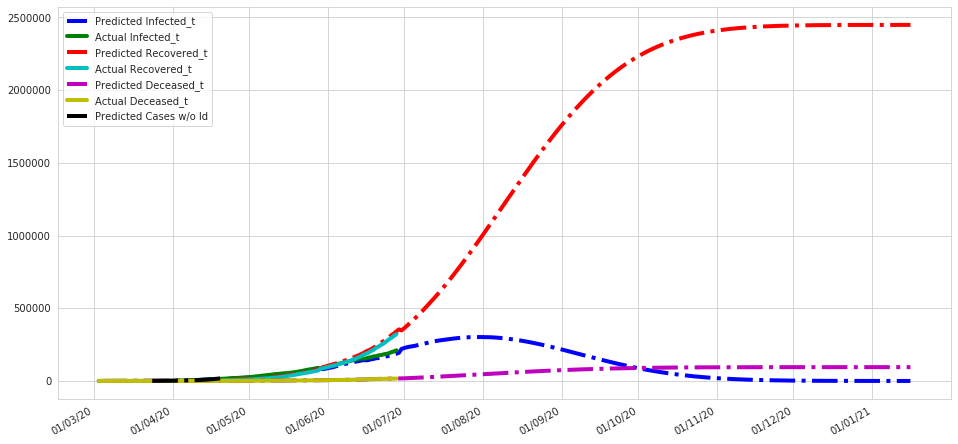

In [41]:
import matplotlib.dates as mdates
# weeks = mdates.WeekdayLocator()  # every month
datelocator = mdates.AutoDateLocator()
months_fmt = mdates.DateFormatter('%d/%m/%y')

    # Load a numpy structured array from yahoo csv data with fields date, open,
    # close, volume, adj_close from the mpl-data/example directory.  This array
    # stores the date as an np.datetime64 with a day unit ('D') in the 'date'
    # column.
    #with cbook.get_sample_data('goog.npz') as datafile:
     #   data = np.load(datafile)['price_data']

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(trial_2.Dates, trial_2.Xt,label ='Predicted Infected_t', color = 'b', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range].infected_t),label ='Actual Infected_t', color = 'g', linestyle = 'solid', linewidth = 4)
ax.plot(trial_2.Dates,trial_2.Rt,label ='Predicted Recovered_t', color = 'r', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range]['Total Recovered']),label ='Actual Recovered_t', color = 'c', linestyle = 'solid', linewidth = 4)
ax.plot(trial_2.Dates, trial_2.Dt,label ='Predicted Deceased_t', color = 'm', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range]['Total Deceased']),label ='Actual Deceased_t', color = 'y', linestyle = 'solid', linewidth = 4)
ax.plot(w_l_pred.iloc[1:].Dates,w_l_pred.iloc[1:].Xt,label ='Predicted Cases w/o ld', color = 'black', linestyle = 'dashdot', linewidth = 4)
#     ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    # format the ticks
ax.xaxis.set_major_locator(datelocator)
ax.xaxis.set_major_formatter(months_fmt)
# ax.axvline(x=30)
# ax.xaxis.set_minor_locator(year)

    # round to nearest years.
    #datemin = np.datetime64(date_actual[1], 'Y')
    #datemax = np.datetime64(date_actual[len(date_actual)-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    #ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
fig.autofmt_xdate()

plt.legend()
#     plt.title(title)

In [42]:
trial_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   319 non-null    object 
 1   Xt      319 non-null    float64
 2   Rt      319 non-null    float64
 3   Dt      319 non-null    float64
dtypes: float64(3), object(1)
memory usage: 10.1+ KB


In [43]:
trial_2 = trial_2.reset_index().drop('index',axis = 1)

In [44]:
trial_2.to_csv('Predicted_SIR_June_30.csv')

# MODULE 3.2:  POISSON REGRESSION: (SIR Predictions + Other Factor)

##  OVERVIEW

This notebook consist of the <b> Forecasting Module </b> of our Solution, This will consider the data from different sources, including the output of the <b> Markov Module </b> i.e the Stages at which a country is in a particular year. This notebook consist of following 6 Sections: 

<b> 1) Importing Packages  </b> <br> 
<b> 2) Loading Datasets and Preprocessing Steps  </b> <br>
<b> 3) ACF and PACF Plots for determine appropriate Lag  </b> <br> 
<b> 4) Data Visualization </b> <br>
<b> 5) Defining Utility Function for Data Modelling </b> <br>
<b> 6) Model Fitting and Results  </b> <br> 






## 1. IMPORTING PACKAGES

In [45]:
# Importing Packages

from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
import math

## 2. LOADING DATASETS AND PREPROCESSING STEPS 

In [1]:
# Reading the dataset

#India = pd.read_csv('../Data/12th May/India_final.csv')
SIR = pd.read_csv('Predicted_SIR_June_30.csv')
stages = pd.read_csv('Covid_cases_and_stages_June_30.csv')
print(stages.info())

## Dropping Unnecessary Columns
SIR.drop('Unnamed: 0', axis = 1,inplace = True)
stages.drop('Unnamed: 0',axis = 1, inplace = True)

## Merging the Dataset to Produce a Combined Datase
SIR = SIR.set_index('Dates')
stages = stages.set_index('Dates')
India = pd.merge(SIR, stages, how='outer',left_index=True,right_index=True)
India.reset_index(inplace=True)

## Removing Unnecessary Columns
India = India.dropna(axis=0, subset=['Xt'])
India = India.drop(['location', 'cum_day', 'new_tests','new_tests_per_thousand'], axis = 1)

India.head()

NameError: name 'pd' is not defined

In [ ]:
India['SIR_total_cases'] = India['Xt'] + India['Rt'] + India['Dt']

In [2]:
India['SIR_cases'] = India['SIR_total_cases'].diff().fillna(0)

NameError: name 'India' is not defined

In [ ]:
India['SIR_cases']

#### Utility Functions

In [50]:
def adding_lagged_values(df, lag, label):
    data = list(df[label])
    lagged_data = []
    for i in range(lag):
        lagged_data.append(0)
    for i in range(lag, len(data)):
        lagged_data.append(data[i-lag])
    col_name = str('lagged_'+label)
    df[col_name] = lagged_data
    df.reset_index()
    return(df)

def impute_tests_data(total_tests, total_cases, round_digit, train_size):
    '''
    Imputing the Testing Data, with the moving average of past three data points, if past three data point are non
    zero, else with the last known value. 
    '''
    x = []
    imputed_total_tests = []
    j = 0
    
    for i, val in enumerate(total_tests):
        
        if math.isnan(val) and j==0:
            continue
        
        elif j==1:
            j = j+1
            for k in range(i+1):
                imputed_total_tests.append(round(np.mean(x)*total_cases[k],round_digit))
        
        elif math.isnan(val) and j>1:
            impute = np.mean(x[len(x)-3:])
            if math.isnan(impute):
                impute = np.mean(x[len(x)-2:])
                if math.isnan(impute):
                    impute = np.mean(x[len(x)-1:])
                else:
                    impute = np.mean(x)
            imputed_total_tests.append(round(impute*total_cases[i],round_digit))
        elif math.isnan(val) == False:
            x.append(val/total_cases[i])
            imputed_total_tests.append(val)
            j = j + 1
    
    imputed_total_tests = list(pd.Series(imputed_total_tests[:train_size]).rolling(3).mean().fillna(np.mean(imputed_total_tests[:2])))
    
    value = []
    for p in range(len(total_tests)):
        if p < train_size:
            value.append(round(imputed_total_tests[p],round_digit))
        else:
            value.append(math.nan)
    return(value)

In [51]:
#################################################################################
#################### Adding Lagged Values to the Dataset ########################
#################################################################################

## Adding some Lagged Columns
India = adding_lagged_values(India, 14, 'stringency_index')
India = adding_lagged_values(India, 14, 'new_cases')

##################################################################################
#################### Imputing the Missing Data in Training Set ###################
##################################################################################

## Initializing the Series to be Imputed
total_tests = (India.total_tests)
total_cases = list(India.total_cases)
new_tests = India.new_tests_smoothed
new_cases = list(India.new_cases)
total_tests_per_thousand = (India.total_tests_per_thousand)
new_tests_per_thousand = (India.new_tests_smoothed_per_thousand)
train_size = len(India.total_cases.dropna())

print('Training Dataset Size is', train_size)
      
## Applying Functions
total_tests = impute_tests_data(total_tests, total_cases,0, train_size)
new_tests = impute_tests_data(new_tests, new_cases,0, train_size)
new_tests_per_thousand = impute_tests_data(new_tests_per_thousand, new_cases,3,train_size)
total_tests_per_thousand = impute_tests_data(new_tests_per_thousand, new_cases,3, train_size)

## Adding Imputed Values to the India Dataframe 
cols = ['total_tests','new_tests_smoothed','total_tests_per_thousand','new_tests_smoothed_per_thousand']
imputed_vals = [total_tests, new_tests, total_tests_per_thousand, new_tests_per_thousand]
India = India.drop(cols, axis = 1)
for i in range(4):
    India[cols[i]] = imputed_vals[i]

Training Dataset Size is 118


In [52]:
India.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 32 to 350
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dates                            319 non-null    object 
 1   Xt                               319 non-null    float64
 2   Rt                               319 non-null    float64
 3   Dt                               319 non-null    float64
 4   continent                        118 non-null    object 
 5   total_cases                      118 non-null    float64
 6   new_cases                        118 non-null    float64
 7   total_deaths                     118 non-null    float64
 8   new_deaths                       118 non-null    float64
 9   total_cases_per_million          118 non-null    float64
 10  new_cases_per_million            118 non-null    float64
 11  total_deaths_per_million         118 non-null    float64
 12  new_deaths_per_millio

In [53]:
India.head(132)

,Dates,Xt,Rt,Dt,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,...,life_expectancy,Stages,SIR_total_cases,SIR_cases,lagged_stringency_index,lagged_new_cases,total_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_smoothed_per_thousand
32,2020-03-04,2.828035,3.404253,0.009523,Asia,6.0,1.0,0.0,0.0,0.004,...,69.66,1.0,6.241811,0.000000,0.00,0.0,3510.0,584.0,0.001,0.001
33,2020-03-05,25.701867,4.716854,0.079977,Asia,28.0,22.0,0.0,0.0,0.020,...,69.66,1.0,30.498698,24.256888,0.00,0.0,3510.0,584.0,0.001,0.001
34,2020-03-06,25.187211,7.328167,0.086916,Asia,29.0,1.0,0.0,0.0,0.021,...,69.66,1.0,32.602294,2.103596,0.00,0.0,3149.0,707.0,0.008,0.001
35,2020-03-07,24.407114,9.142781,0.090600,Asia,31.0,2.0,0.0,0.0,0.022,...,69.66,1.0,33.640495,1.038201,0.00,0.0,1820.0,346.0,0.008,0.000
36,2020-03-08,31.389122,5.417784,0.101454,Asia,34.0,3.0,0.0,0.0,0.025,...,69.66,1.0,36.908360,3.267864,0.00,0.0,2542.0,361.0,0.008,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2020-07-09,257427.375461,496681.754111,24478.431746,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,778587.561318,23941.388726,76.39,16922.0,NaN,NaN,NaN,NaN
160,2020-07-10,261587.789096,515233.711069,25337.624825,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,802159.124990,23571.563672,76.39,17296.0,NaN,NaN,NaN,NaN
161,2020-07-11,265439.741332,533920.220556,26213.642317,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,825573.604204,23414.479214,76.39,18552.0,NaN,NaN,NaN,NaN
162,2020-07-12,269379.200502,553339.490854,27105.681086,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,849824.372442,24250.768238,76.39,19906.0,NaN,NaN,NaN,NaN


In [54]:
India.describe()

,Xt,Rt,Dt,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,life_expectancy,Stages,SIR_total_cases,SIR_cases,lagged_stringency_index,lagged_new_cases,total_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_smoothed_per_thousand
count,319.000000,3.190000e+02,319.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,...,1.180000e+02,118.000000,3.190000e+02,319.000000,132.000000,132.000000,1.180000e+02,118.000000,118.000000,118.000000
mean,92501.194307,1.227801e+06,50004.099590,117967.220339,4803.686441,3582.423729,143.161017,85.483161,3.480924,2.595966,...,6.966000e+01,2.677966,1.370307e+06,7974.283547,71.443485,4294.204545,1.979299e+06,62464.389831,0.043076,0.045271
std,104929.304774,1.043956e+06,40427.088542,154310.798443,5415.514750,4732.656928,219.630925,111.819057,3.924271,3.429464,...,9.990019e-14,1.211634,1.074990e+06,9004.929586,31.278507,5328.982238,2.343973e+06,58869.026453,0.040912,0.042644
min,2.828035,3.404253e+00,0.009523,6.000000,1.000000,0.000000,0.000000,0.004000,0.001000,0.000000,...,6.966000e+01,1.000000,6.241811e+00,0.000000,0.000000,0.000000,1.820000e+03,87.000000,0.000000,0.000000
25%,2768.420106,5.919982e+04,3880.360958,2451.250000,383.500000,59.000000,6.750000,1.776000,0.278250,0.043000,...,6.966000e+01,2.000000,1.270674e+05,275.363990,75.460000,73.750000,5.207950e+04,2761.500000,0.002250,0.002000
50%,41943.178225,1.233606e+06,55622.775551,38658.000000,2423.000000,1259.500000,73.000000,28.013000,1.756000,0.913000,...,6.966000e+01,3.000000,1.581163e+06,3685.470538,79.170000,1548.000000,8.035530e+05,44111.000000,0.026000,0.032000
75%,167684.472459,2.400234e+06,93904.148053,188437.000000,8327.750000,5336.500000,205.500000,136.547750,6.034250,3.867250,...,6.966000e+01,4.000000,2.517594e+06,14861.971384,96.300000,7099.250000,3.455071e+06,108365.000000,0.076000,0.078500
max,302080.792408,2.448718e+06,95055.049827,566840.000000,19906.000000,16893.000000,2003.000000,410.752000,14.425000,12.241000,...,6.966000e+01,4.000000,2.543803e+06,26023.256178,100.000000,19906.000000,8.000246e+06,197637.000000,0.136000,0.143000


## 4. DATA VISUALIZATION

In [55]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

India['Date']= India.apply(lambda row: date_conversion(row.Dates), axis = 1)

In [56]:
# Plotting the Confirmed Cases with Date
import matplotlib.pyplot as plt

def plot_data(df, label1, interval1):
    
    weeks = mdates.DayLocator(interval = interval1)  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')
    
    dates = df['Date']
    values = df[label1]


    fig, ax = plt.subplots()
    ax.plot(dates, values,label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    # ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.


    fig.autofmt_xdate()

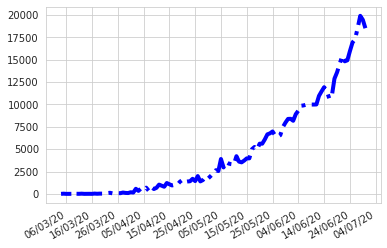

In [57]:
plot_data(India, 'new_cases',10)

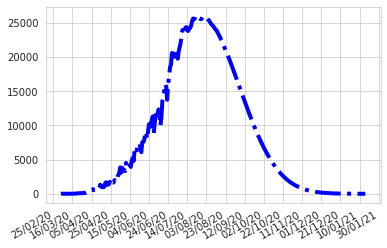

In [58]:
plot_data(India, 'SIR_cases',20)

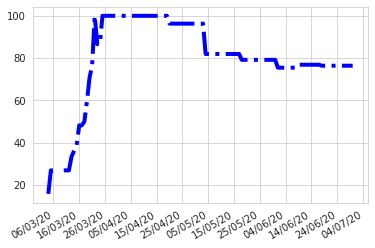

In [59]:
plot_data(India, 'stringency_index',10)

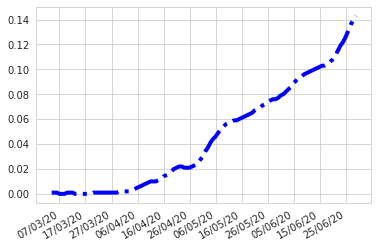

In [60]:
plot_data(India, 'new_tests_smoothed_per_thousand',10)

## PLOTTING THE CORRELATION GRAPH

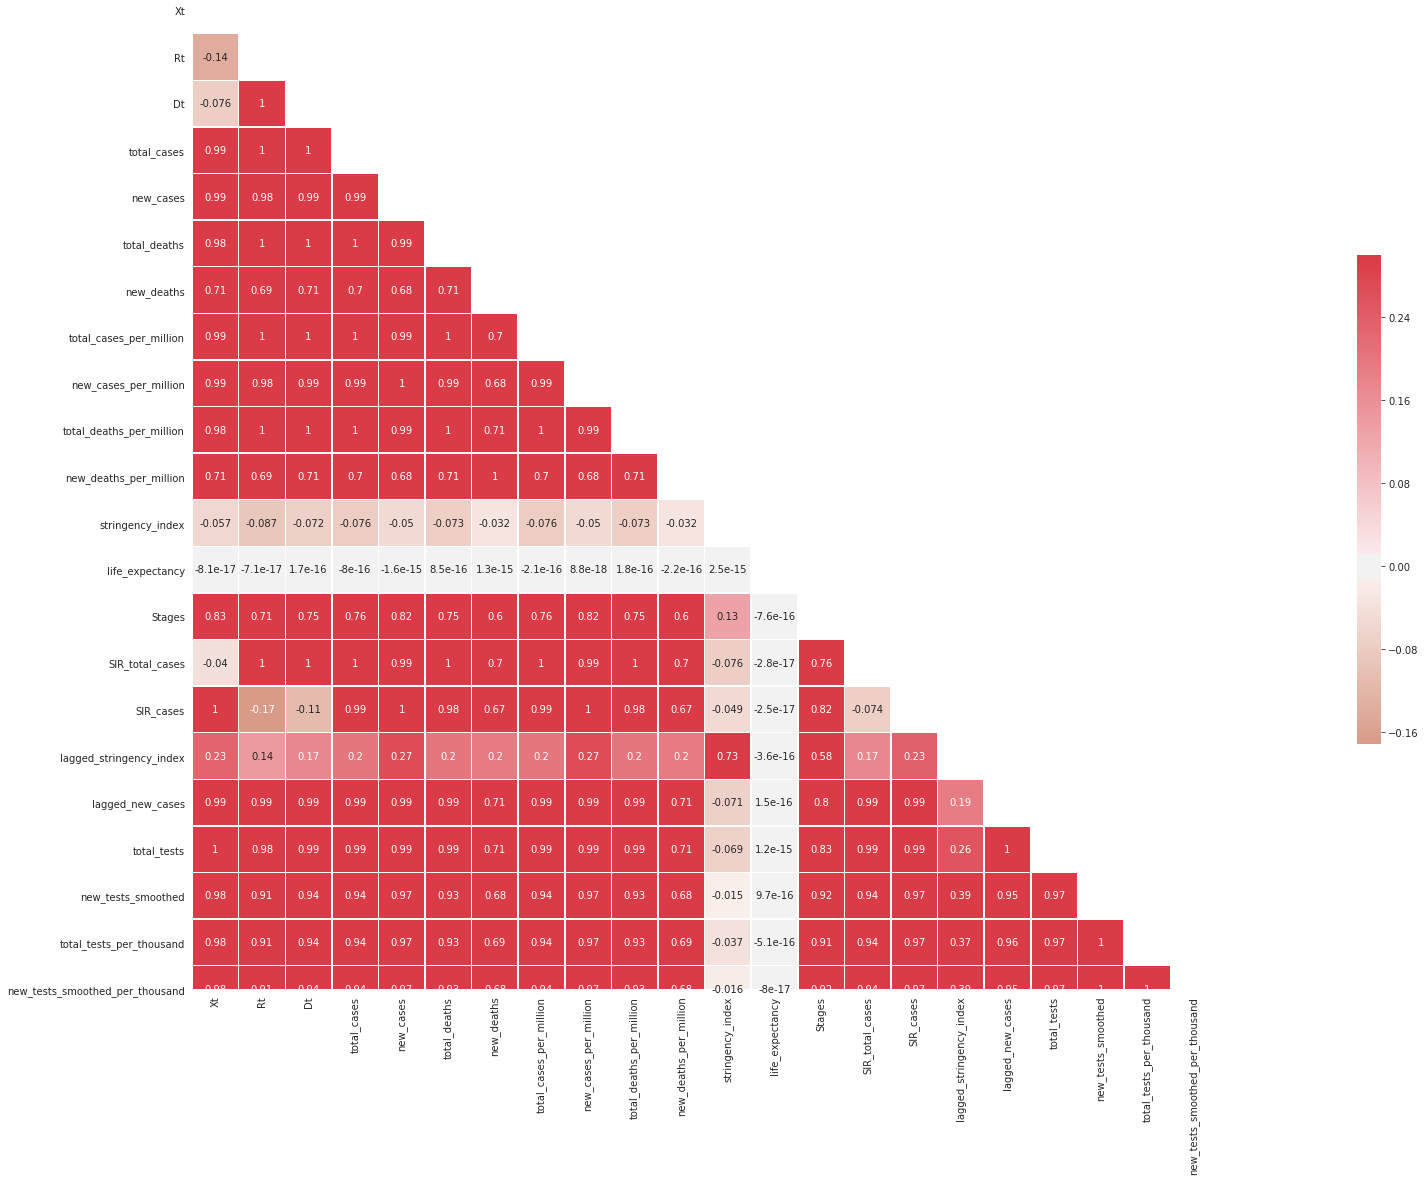

In [61]:
# Compute the correlation matrix
corr = India.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [62]:
India.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 32 to 350
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dates                            319 non-null    object 
 1   Xt                               319 non-null    float64
 2   Rt                               319 non-null    float64
 3   Dt                               319 non-null    float64
 4   continent                        118 non-null    object 
 5   total_cases                      118 non-null    float64
 6   new_cases                        118 non-null    float64
 7   total_deaths                     118 non-null    float64
 8   new_deaths                       118 non-null    float64
 9   total_cases_per_million          118 non-null    float64
 10  new_cases_per_million            118 non-null    float64
 11  total_deaths_per_million         118 non-null    float64
 12  new_deaths_per_millio

## 5. DEFINITION OF UTILITY FUNCTIONS FOR MODELLING DATA

In [144]:
## Expressions for New_cases
expr0 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr2 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr3 = '''new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed'''

# Expressions for New_deaths
expr4 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr5 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr6 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''


def train_test_split(df,ratio, expr):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

    
def train_test_future_split(df, expr, training_size, prediction_size):
    df_train = df.head(training_size)
    test_size = training_size + prediction_size
    df_test = df.head(test_size)

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

def train_model(y_train, X_train):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    print(model.summary())
    return(model)

def predict(model, X_test):
    poisson_predictions = model.get_prediction(X_test)
    #.summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    return(predictions_summary_frame['mean'])
    
    
def plot_results(predictions_summary_frame,X_test, y_test, country, label):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label]
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)

def plot_results_1(predictions_summary_frame,X_train, y_train, X_test, y_test, country, label1):
    predicted_counts=predictions_summary_frame
    actual_counts = y_train[label1]    
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 '+label1))
    predicted, = plt.plot(X_test.index, predicted_counts, 'g', label='Predicted counts')
    actual, = plt.plot(X_train.index, actual_counts, 'r', label='Actual counts')
    #SIR, = plt.plot(X_test.index, I_x, 'bo-', label='SIR Predictions')
    #Wt_predictions, = plt.plot(X_test.index, avg, 'yo-',label = 'Weighted Predictions')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)
    
def plot_actual_vs_output(predicted_counts, actual_counts):
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()

## 6. NEW CASES MODEL: TRAINING AND RESULTS

## STEP 1: TEST-TRAIN SPLIT

In [64]:
X_train, y_train, X_test, y_test = train_test_split(India, 0.9,expr1) 
#X_future, y_future, p, q = train_test_split(India_future,1, expr)

Training data set length=288
Testing data set length=31


## STEP 2: MODEL TRAINING AND SUMMARY

In [65]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                  105
Model:                            GLM   Df Residuals:                       96
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5256.0
Date:                Sat, 18 Jul 2020   Deviance:                       9578.3
Time:                        13:33:50   Pearson chi2:                 8.95e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## STEP 3: PREDICTIONS

In [66]:
predictions_frame = (predict(model, X_test)).rolling(1).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

             mean    mean_se  mean_ci_lower  mean_ci_upper
33      26.422118   1.107782      24.337720      28.685035
43      41.171757   1.460273      38.406890      44.135664
65     653.470119   4.776029     644.176001     662.898333
66     664.078124   4.756564     654.820564     673.466564
75     940.771955   5.657841     929.747890     951.926733
82    1051.006392   5.865203    1039.573444    1062.565077
84     985.881904   6.651331     972.931347     999.004844
87    1161.170015   6.716869    1148.079541    1174.409747
101   3472.992359  19.310910    3435.349162    3511.048036
136   9915.802154  36.761165    9844.012730    9988.115116
144  16038.610109  56.118374   15928.996403   16148.978110


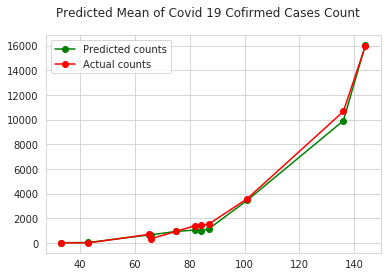

<function mean_squared_error at 0x7ffa32fb5ea0> 3055051199010.6343
<function r2_score at 0x7ffa32fba158> 0.9956817541691373
<function median_absolute_error at 0x7ffa32fba048> 706461.1691819504
<function mean_absolute_error at 0x7ffa32fb5e18> 1237919.9617831511


In [67]:
predicted_counts, actual_counts = plot_results(predictions_frame, X_test, y_test.rolling(1).mean().fillna(0), India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: 
    print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

## New Cases

In [68]:

## Expressions for New_cases
expr0 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand'''
expr2 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr3 = '''new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed'''
expr4 = '''new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed'''

Training data set length=96
Testing data set length=22
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   96
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11420.
Date:                Sat, 18 Jul 2020   Deviance:                       22005.
Time:                        13:33:51   Pearson chi2:                 1.95e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

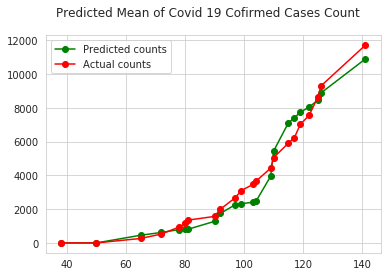

<function mean_squared_error at 0x7ffa32fb5ea0> 399238.0985580997
<function r2_score at 0x7ffa32fba158> 0.9628630605447039
<function median_absolute_error at 0x7ffa32fba048> 411.7521596050924
<function mean_absolute_error at 0x7ffa32fb5e18> 508.2607036751995
Training data set length=80
Testing data set length=38
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   80
Model:                            GLM   Df Residuals:                       72
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2764.2
Date:                Sat, 18 Jul 2020   Deviance:                       4825.6
Time:                        13:33:52   Pearson chi2:                 4.54e+03
No. Iterations:                     8                 

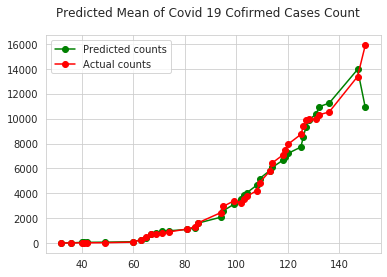

<function mean_squared_error at 0x7ffa32fb5ea0> 805360.0283200295
<function r2_score at 0x7ffa32fba158> 0.9571753344910104
<function median_absolute_error at 0x7ffa32fba048> 271.03248923310707
<function mean_absolute_error at 0x7ffa32fb5e18> 403.17825839365963
Training data set length=105
Testing data set length=13
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                  105
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3956.9
Date:                Sat, 18 Jul 2020   Deviance:                       6980.0
Time:                        13:33:52   Pearson chi2:                 6.64e+03
No. Iterations:                     8              

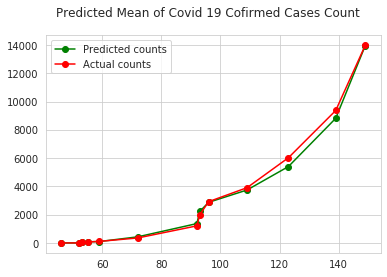

<function mean_squared_error at 0x7ffa32fb5ea0> 62393.18373083122
<function r2_score at 0x7ffa32fba158> 0.9964123848624149
<function median_absolute_error at 0x7ffa32fba048> 47.39022083645341
<function mean_absolute_error at 0x7ffa32fb5e18> 148.62837776151744
Training data set length=94
Testing data set length=24
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   94
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24334.
Date:                Sat, 18 Jul 2020   Deviance:                       47830.
Time:                        13:33:53   Pearson chi2:                 6.89e+04
No. Iterations:                     7                

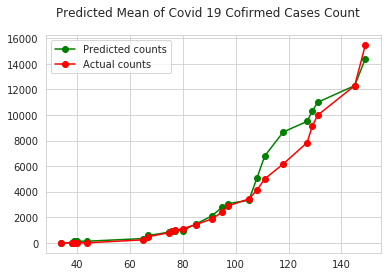

<function mean_squared_error at 0x7ffa32fb5ea0> 707161.5275481818
<function r2_score at 0x7ffa32fba158> 0.9612502192048724
<function median_absolute_error at 0x7ffa32fba048> 126.05641894079696
<function mean_absolute_error at 0x7ffa32fb5e18> 496.6913802740094
Training data set length=96
Testing data set length=22
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   96
Model:                            GLM   Df Residuals:                       91
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3999.2
Date:                Sat, 18 Jul 2020   Deviance:                       7130.1
Time:                        13:33:53   Pearson chi2:                 6.69e+03
No. Iterations:                     8                

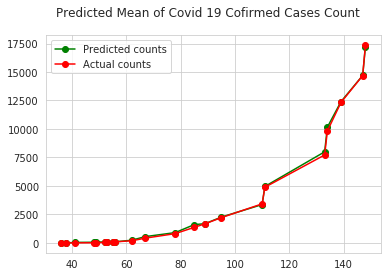

<function mean_squared_error at 0x7ffa32fb5ea0> 14237.980509130995
<function r2_score at 0x7ffa32fba158> 0.9994778641992368
<function median_absolute_error at 0x7ffa32fba048> 46.74329531816229
<function mean_absolute_error at 0x7ffa32fb5e18> 79.21119881539393


In [69]:
expressions = [expr0, expr1, expr2, expr3, expr4]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.8, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_cases')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [70]:
for i in rmse.keys():
    print(i, rmse[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 631.8529089575355
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 897.4185357568839
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 249.7862761058566
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 840.9289670050508
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 119.32300913541778


In [71]:
for i in mae.keys():
    print(i, mae[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 508.2607036751995
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 403.17825839365963
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 148.62837776151744
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 496.6913802740094
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 79.21119881539393


In [72]:
for i in r2_Score.keys():
    print(i, r2_Score[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 0.9628630605447039
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 0.9571753344910104
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 0.9964123848624149
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 0.9612502192048724
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 0.9994778641992368


## New Deaths

In [73]:
# Expressions for New_deaths
expr4 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index'''
expr5 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr6 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''


Training data set length=83
Testing data set length=35
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   83
Model:                            GLM   Df Residuals:                       75
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1052.8
Date:                Sat, 18 Jul 2020   Deviance:                       1682.0
Time:                        13:33:55   Pearson chi2:                 1.74e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

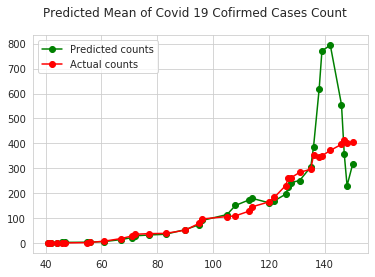

<function mean_squared_error at 0x7ffa32fb5ea0> 14454.292050374146
<function r2_score at 0x7ffa32fba158> 0.33761511262234045
<function median_absolute_error at 0x7ffa32fba048> 7.772131692214472
<function mean_absolute_error at 0x7ffa32fb5e18> 55.753130081707475
Training data set length=81
Testing data set length=37
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   81
Model:                            GLM   Df Residuals:                       72
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1519.5
Date:                Sat, 18 Jul 2020   Deviance:                       2602.0
Time:                        13:33:56   Pearson chi2:                 3.01e+03
No. Iterations:                     8              

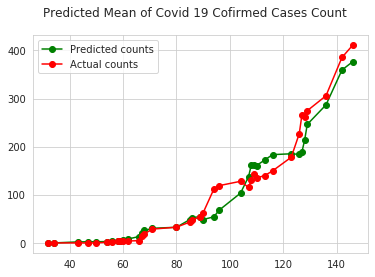

<function mean_squared_error at 0x7ffa32fb5ea0> 670.7635179793801
<function r2_score at 0x7ffa32fba158> 0.9487891679666989
<function median_absolute_error at 0x7ffa32fba048> 7.172101940970606
<function mean_absolute_error at 0x7ffa32fb5e18> 17.43265467228706
Training data set length=76
Testing data set length=42
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   76
Model:                            GLM   Df Residuals:                       69
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1444.4
Date:                Sat, 18 Jul 2020   Deviance:                       2456.4
Time:                        13:33:56   Pearson chi2:                 2.75e+03
No. Iterations:                     7                 

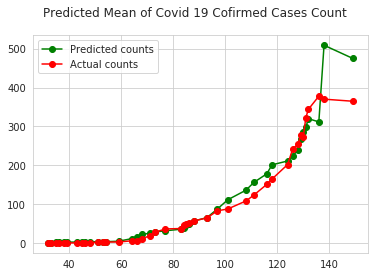

<function mean_squared_error at 0x7ffa32fb5ea0> 1020.1134881585735
<function r2_score at 0x7ffa32fba158> 0.9338091273147927
<function median_absolute_error at 0x7ffa32fba048> 4.7053462045898815
<function mean_absolute_error at 0x7ffa32fb5e18> 15.623789457956999
Training data set length=82
Testing data set length=36
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   82
Model:                            GLM   Df Residuals:                       78
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -826.58
Date:                Sat, 18 Jul 2020   Deviance:                       1245.4
Time:                        13:33:57   Pearson chi2:                 1.47e+03
No. Iterations:                     7              

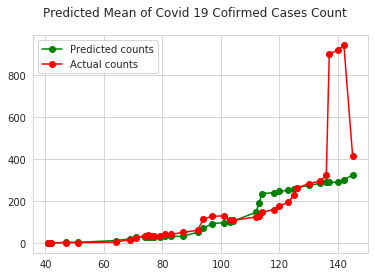

<function mean_squared_error at 0x7ffa32fb5ea0> 33932.62902048613
<function r2_score at 0x7ffa32fba158> 0.4351860539352669
<function median_absolute_error at 0x7ffa32fba048> 10.467131318880128
<function mean_absolute_error at 0x7ffa32fb5e18> 73.69081897339134


In [74]:
expressions = [expr4, expr5, expr6, expr7]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_deaths')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [75]:
for i in rmse.keys():
    print(i,': ', round(rmse[i],4))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index :  120.226
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed :  25.8991
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed :  31.9392
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed :  184.2081


In [76]:
for i in mae.keys():
    print(i, round(mae[i],4))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index 55.7531
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed 17.4327
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 15.6238
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed 73.6908


In [77]:
for i in r2_Score.keys():
    print(i, round(r2_Score[i]))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index 0.0
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed 1.0
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 1.0
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed 0.0


# Predicting for Future

## New COVID Cases

In [78]:
def prepare_future_data(df_test,train_size ,prediction_size):
    
    df_test= India.head(train_size+prediction_size)
    
    if prediction_size>0:
        cols = ['total_tests','new_tests_smoothed','total_tests_per_thousand','new_tests_smoothed_per_thousand','stringency_index']
        
        for col in cols:
            val = (India[col].dropna()).tolist()
            x = df_test[col].fillna(val[-1])
            df_test = df_test.drop(col, axis=1)
            df_test[col] = x
    
    ## Generating New Stages
    Stages = list(df_test.Stages)[:train_size]
    last = int(Stages[-1])
    sec_last = int(Stages[-2])
    arr = getStages(fpt, sec_last,last, prediction_size)
    
    for i in range(prediction_size):
        Stages.append(arr[i])
    
    print(len(Stages))
    df_test = df_test.drop('Stages',axis = 1)
    df_test['Stages'] = Stages
    
    ## New_cases_filling na
    new_cases = list(df_test.new_cases.fillna(0))
    df_test =df_test.drop('new_cases', axis = 1)
    df_test['new_cases'] = new_cases
    df_test = df_test.fillna(0)
    return(df_test)

## STEP 1: TEST-TRAIN SPLIT

## Add the number of days for which you have to predict in future

In [158]:
expr1 = '''new_cases ~ stringency_index + total_tests_per_thousand + Stages + SIR_cases '''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''

In [103]:
print("Size of the Dataset we have for India:", train_size)

Size of the Dataset we have for India: 118


In [126]:
train_size_1 = 119   
train_size_2 = 119  

India_filtered_1 = India.head(train_size_1)
India_filtered_2 = India.head(train_size_2)

## Number of Days you have to predict in future
prediction_days = 100
India_future = prepare_future_data(India_filtered_1, train_size_1, prediction_days)

## Splitting the dataset into Test and Train for Daily Cases
X_train, y_train, X_test, y_test = train_test_split(India_filtered_1,1, expr1) 
X_India, y_India, p, q = train_test_split(India_future,1, expr1)

## Splitting the dataset into Test and Train for Daily Deaths
X_train_d, y_train_d, X_test_d, y_test_d = train_test_split(India_filtered_1,1, expr7) 
X_India_d, y_India_d, p_d, q_d = train_test_split(India_future,1, expr7)

219
Training data set length=119
Testing data set length=0
Training data set length=219
Testing data set length=0
Training data set length=119
Testing data set length=0
Training data set length=219
Testing data set length=0


In [127]:
(X_India.head(130))

,Intercept,stringency_index,Stages,SIR_cases
32,1.0,15.74,1.0,0.000000
33,1.0,26.85,1.0,24.256888
34,1.0,26.85,1.0,2.103596
35,1.0,26.85,1.0,1.038201
36,1.0,26.85,1.0,3.267864
...,...,...,...,...
157,1.0,76.39,4.0,21980.193036
158,1.0,76.39,4.0,22968.982867
159,1.0,76.39,4.0,23941.388726
160,1.0,76.39,4.0,23571.563672


## STEP 2: MODEL TRAINING AND SUMMARY

In [159]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                  118
Model:                            GLM   Df Residuals:                      114
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11809.
Date:                Sat, 18 Jul 2020   Deviance:                       22572.
Time:                        20:06:12   Pearson chi2:                 2.12e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.2762      0.032  

In [160]:
model_d = train_model(y_train_d, X_train_d)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                  116
Model:                            GLM   Df Residuals:                      112
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2820.7
Date:                Sat, 18 Jul 2020   Deviance:                       5026.7
Time:                        20:06:12   Pearson chi2:                 9.56e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [161]:
X_India.to_csv('training_data.csv')

## STEP 3: PREDICTIONS

In [162]:
predictions_frame = (predict(model, X_India)).rolling(10).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

           mean   mean_se  mean_ci_lower  mean_ci_upper
32    88.811444  2.254570      84.500699      93.342099
33   106.963505  2.379209     102.400527     111.729810
34   106.774347  2.375121     102.219215     111.532467
35   106.765258  2.374924     102.210503     111.522985
36   106.784280  2.375336     102.228735     111.542830
..          ...       ...            ...            ...
246  398.340830  3.843807     390.877902     405.946246
247  390.183554  3.759347     382.884504     397.621748
248  382.412903  3.679230     375.269310     389.692481
249  375.009138  3.603207     368.013063     382.138211
250  367.964520  3.531158     361.108259     374.950958

[219 rows x 4 columns]


In [121]:
Results = pd.DataFrame()

dates = list(whole_data[whole_data['Dates']>=pd.to_datetime('2020-06-30')]['Dates'][-14:])
actual = list(whole_data[whole_data['Dates']>=pd.to_datetime('2020-06-30')]['new_cases'])[-14:]
predicted = (predictions_frame[-14:])
SIR = X_India.tail(14)

sir = list(SIR['SIR_cases'])
print(len(actual), len(predicted), len(sir))
print(predicted)

Results['Dates'] = dates
Results['Actual Counts'] = actual
Results['Poisson Predictions'] = predicted
Results['SIR Predictions'] = sir



##
RMSE_SIR = np.sqrt(mean_squared_error(actual, sir))
MAE_SIR = mean_absolute_error(actual, sir)
RMSE_Poisson = np.sqrt(mean_squared_error(actual, predicted))
MAE_Poisson = mean_absolute_error(actual, predicted)

print("Percentage Root Mean Square Error for SIR               :", round(RMSE_SIR/np.mean(actual),3))
print("Percentage Root Mean Square Error for Poisson Regression:", round(RMSE_Poisson/np.mean(actual),3))
print("Percentage Mean Absolute Error for SIR                  :", round(MAE_SIR/np.mean(actual),3))
print("Percentage Mean Absolute Error for Poisson Regression   :", round(MAE_Poisson/np.mean(actual),3))

14 14 14
151    20649.621468
152    21376.791171
153    21279.144188
154    21120.478942
155    21554.245955
156    21845.932335
157    22185.951452
158    23194.346001
159    24811.493170
160    25910.121401
161    26714.983886
162    27679.599464
163    28298.370528
164    28266.401874
Name: mean, dtype: float64
Percentage Root Mean Square Error for SIR               : 0.123
Percentage Root Mean Square Error for Poisson Regression: 0.061
Percentage Mean Absolute Error for SIR                  : 0.105
Percentage Mean Absolute Error for Poisson Regression   : 0.044


In [122]:
X_India.tail(15)

,Intercept,stringency_index,Stages,SIR_cases
150,1.0,76.39,4.0,19490.151746
151,1.0,76.39,4.0,20596.018862
152,1.0,76.39,4.0,21070.355929
153,1.0,76.39,4.0,20298.435480
154,1.0,76.39,4.0,19740.797316
155,1.0,76.39,4.0,20786.564375
156,1.0,76.39,4.0,21409.824726
157,1.0,76.39,4.0,21980.193036
158,1.0,76.39,4.0,22968.982867
159,1.0,76.39,4.0,23941.388726


In [183]:
def plot_data(dates,actual,predicted,sir, interval1):
    
    weeks = mdates.DayLocator(interval = interval1)  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')
    
    # dates = df['Date']
    # values = df[label1]
    dates1 = pd.Series(dates)
    dates2 = pd.Series(dates[:len(actual)])
    dates3 = pd.Series(dates[:len(sir)])
    
    label1 = 'Actual Cases'
    label2 = 'Poisson Regression Predictions'
    label3 = "SIR Predictions"

    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(dates2, pd.Series(actual).rolling(2).mean(),label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    ax.plot(dates1, predicted,label = label2, color = 'g', linewidth = 2)
    ax.plot(dates3, sir,label = label3, color = 'r', linewidth = 2)
    
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    
    plt.legend()
    plt.title('Predictions for Next 15 Days')


    fig.autofmt_xdate()
    
#plot_data(dates, actual, predicted,sir, 3)

In [177]:
X_India.head(150)

,Intercept,stringency_index,Stages,SIR_cases
32,1.0,15.74,1.0,0.000000
33,1.0,26.85,1.0,24.256888
34,1.0,26.85,1.0,2.103596
35,1.0,26.85,1.0,1.038201
36,1.0,26.85,1.0,3.267864
...,...,...,...,...
177,1.0,76.39,4.0,25649.624758
178,1.0,76.39,4.0,25509.824141
179,1.0,76.39,4.0,25584.334431
180,1.0,76.39,4.0,25801.951925


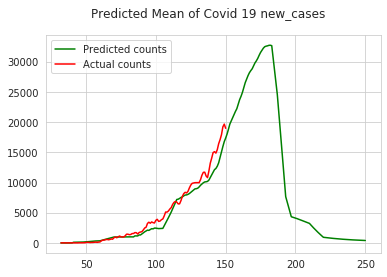

In [189]:
predicted_counts, actual_counts = plot_results_1(predictions_frame,X_train, y_train.rolling(2).mean().fillna(0),X_India, y_India, India, 'new_cases')


In [190]:
dates = list(India_future.Dates)
dates = [pd.to_datetime(dates[i]) for i in range(len(India_future))]
sir = list(India_future.SIR_cases)
dates_actual = dates[:len(actual_counts)]
#actual_counts = India_future
print(len(predicted_counts), len(actual_counts),len(sir))

219 118 219


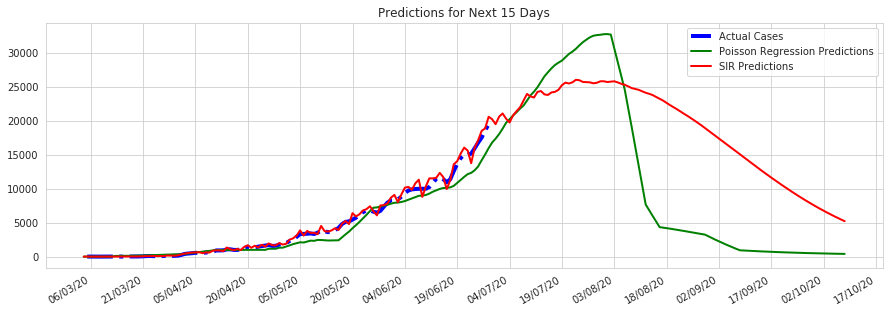

In [191]:
plot_data(dates, actual_counts, predicted_counts, sir, 15)

In [114]:
import matplotlib.pyplot as plt


566840
14 14 14 14
Percentage Root Mean Square Error for SIR               : 0.01702
Percentage Root Mean Square Error for Poisson Regression: 0.00469
Percentage Mean Absolute Error for SIR                  : 0.01313
Percentage Mean Absolute Error for Poisson Regression   : 0.00438


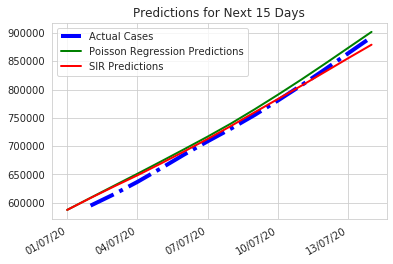

In [115]:
###################################################################
#############  Cumulative Cases Counts ############################
###################################################################
cumm_actual_counts= []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-06-30')]['total_cases'])
print(counts)
for i in actual:
    counts += i
    cumm_actual_counts.append(counts)
    
cumm_poisson_counts = []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-06-30')]['total_cases'])
for i in predicted:
    counts+=i
    cumm_poisson_counts.append(counts)
    
cumm_sir_counts = []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-06-30')]['total_cases'])
for i in sir:
    counts+=i
    cumm_sir_counts.append(counts)

print(len(dates), len(cumm_actual_counts), len(cumm_poisson_counts), len(cumm_sir_counts))
plot_data(dates, cumm_actual_counts, cumm_poisson_counts, cumm_sir_counts, 3)

## Results 
Results['Total Cases Actual'] = cumm_actual_counts
Results['Total Poisson Predicted Cases'] = cumm_poisson_counts
Results['Total SIR Predicted Cases'] = cumm_sir_counts

RMSE_SIR = np.sqrt(mean_squared_error(cumm_actual_counts, cumm_sir_counts))
MAE_SIR = mean_absolute_error(cumm_actual_counts, cumm_sir_counts)
RMSE_Poisson = np.sqrt(mean_squared_error(cumm_actual_counts, cumm_poisson_counts))
MAE_Poisson = mean_absolute_error(cumm_actual_counts, cumm_poisson_counts)

print("Percentage Root Mean Square Error for SIR               :", round(RMSE_SIR/np.mean(cumm_actual_counts),5))
print("Percentage Root Mean Square Error for Poisson Regression:", round(RMSE_Poisson/np.mean(cumm_actual_counts),5))
print("Percentage Mean Absolute Error for SIR                  :", round(MAE_SIR/np.mean(cumm_actual_counts),5))
print("Percentage Mean Absolute Error for Poisson Regression   :", round(MAE_Poisson/np.mean(cumm_actual_counts),5))


###################################################################
###############   Cumulative Death Counts    ######################
###################################################################
# cumm_actual_counts_d= []
# counts = 0
# for i in actual_counts_d:
#     counts += i
#     cumm_actual_counts_d.append(counts)

# cumm_predicted_counts_d = []
# counts = 0
# for i in predicted_counts_d:
#     counts+=i
#     cumm_predicted_counts_d.append(counts)

In [ ]:
Results.head(14)

## Government Policy Variation

In [ ]:
def stringency_index_value(df, label):
    value = (df['lagged_stringency_index']).tolist()
    if label == 'No Lockdown':
        array = np.zeros(len(value))
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    elif label == 'Partial Lockdown':
        array = [i/2 for i in value]
        #1print(array)
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    elif label == 'Full Lockdown':
        array = value
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    return(df)

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

def train_test_split(df,ratio, expr, label):
    mask = np.random.rand(len(df)) < ratio
    df = stringency_index_value(df, label)
    df_train = df[mask]
    df_test = df[~mask]
    df_trains = df_train.dropna()
    df_train_dates = df_trains.apply(lambda row: date_conversion(row.Dates), axis = 1)
    df_tests = df_test.dropna()
    df_test_dates = df_tests.apply(lambda row: date_conversion(row.Dates), axis = 1)
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_trains, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_tests, return_type='dataframe')
    return X_train, y_train, X_test, y_test,df_test_dates



In [ ]:
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index+ total_tests_per_thousand'''

In [ ]:
India = adding_lagged_values(India, 38, 'stringency_index')
India = adding_lagged_values(India, 14, 'new_cases')

In [ ]:
X_train, y_train, X_test, y_test, test_dates = train_test_split(India, 1,expr1, 'Full Lockdown') 
X_train_nld, y_train_nld, X_test, y_test, dates = train_test_split(India, 1,expr1, 'No Lockdown') 

In [ ]:
train_size = len(X_train)
print(train_size)

In [ ]:
model = train_model(y_train, X_train)

In [ ]:
predictions_frame = (predict(model, X_train_nld)).rolling(2).mean().fillna(0)
len(predictions_frame)

In [ ]:
predicted_counts, actual_counts = plot_results_1(predictions_frame,X_train, y_train.rolling(5).mean().fillna(0),X_train_nld, y_train_nld, India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: {}
    #print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

In [ ]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()
actual_dates = India.head(train_size).apply(lambda row: date_conversion(row.Dates), axis = 1)
predicted_dates = India.head(train_size+1).apply(lambda row: date_conversion(row.Dates), axis = 1)

In [ ]:
def plot_results_final(acutal_dates, actual_counts, predicted_dates, predicted_counts, label1, label2, title):
    # months = mdates.MonthLocator()   # every year
    weeks = mdates.WeekdayLocator()  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')

    # Load a numpy structured array from yahoo csv data with fields date, open,
    # close, volume, adj_close from the mpl-data/example directory.  This array
    # stores the date as an np.datetime64 with a day unit ('D') in the 'date'
    # column.
    #with cbook.get_sample_data('goog.npz') as datafile:
     #   data = np.load(datafile)['price_data']

    fig, ax = plt.subplots()
    ax.plot(actual_dates, actual_counts,label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    #ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    #datemin = np.datetime64(date_actual[1], 'Y')
    #datemax = np.datetime64(date_actual[len(date_actual)-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    #ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    plt.legend()
    plt.title(title)
    plt.show()


In [ ]:
plot_results_final(actual_dates, actual_counts, predicted_dates, predicted_counts,'Current Situation', 'Zero Stringency Index', 'New_cases_predictions_India' )

In [ ]:
cumm_actual_counts= []
counts = 0
for i in actual_counts:
    counts += i
    cumm_actual_counts.append(counts)

In [ ]:
cumm_predicted_counts = []
counts = 0
for i in predicted_counts:
    counts+=i
    cumm_predicted_counts.append(counts)

In [ ]:
plot_results_final(actual_dates, cumm_actual_counts, predicted_dates, cumm_predicted_counts,'Current Situation', 'Zero Stringency Index', 'Cummulative Covid 19 Cases India' )

In [ ]:
X_train_d, y_train_d, X_test_d, y_test_d, test_dates_d = train_test_split(India, 1,expr7, 'Full Lockdown') 
X_train_nld_d, y_train_nld_d, X_test_d, y_test_d, dates_d = train_test_split(India, 1,expr7, 'No Lockdown') 

In [ ]:
model = train_model(y_train_d, X_train_d)

In [ ]:
predictions_frame_d = (predict(model, X_train_nld_d)).rolling(2).mean().fillna(0)
len(predictions_frame_d)

In [ ]:
predicted_counts_d, actual_counts_d = plot_results_1(predictions_frame_d,X_train_d, y_train_d.rolling(5).mean().fillna(0),X_train_nld, y_train_nld, India, 'new_deaths')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: {}
    #print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

In [ ]:
plot_results_final(actual_dates, actual_counts_d, predicted_dates, predicted_counts_d,'Current Situation', 'Zero Stringency Index', 'Deaths_predictions_India' )

In [ ]:
cumm_actual_counts_d= []
counts = 0
for i in actual_counts_d:
    counts += i
    cumm_actual_counts_d.append(counts)

In [ ]:
cumm_predicted_counts_d = []
counts = 0
for i in predicted_counts_d:
    counts+=i
    cumm_predicted_counts_d.append(counts)

In [ ]:
plot_results_final(actual_dates, cumm_actual_counts_d, predicted_dates, cumm_predicted_counts_d,'Current Situation', 'Zero Stringency Index', 'Cummulative Covid 19 Cases India' )